<a href="https://colab.research.google.com/github/tek5030/factor_graph_example/blob/master/gtsam_planar_slam_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install GTSAM library

In [1]:
!pip install gtsam

     |████████████████████████████████| 5.5MB 7.1MB/s 


Add a function for plotting points

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches

def plot_point2_on_axes(axes, point, axis_length=0.1, covariance=None):
    origin = point
    axes.plot(point[0], point[1], '.')

    if covariance is not None:
        gPp = covariance[0:2, 0:2]

        w, v = np.linalg.eig(gPp)

        # k = 2.296
        k = 5.0

        angle = np.arctan2(v[1, 0], v[0, 0])
        e1 = patches.Ellipse(origin, np.sqrt(w[0]*k), np.sqrt(w[1]*k),
                             np.rad2deg(angle), fill=False)
        axes.add_patch(e1)

# Planar SLAM example

Example from https://github.com/borglab/gtsam/blob/develop/python/gtsam/examples/Pose2SLAMExample.py

## Factor graph
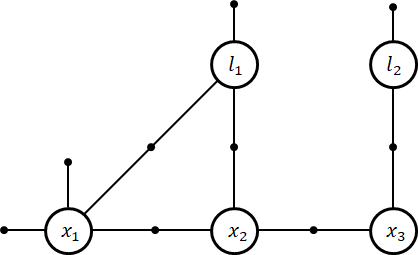

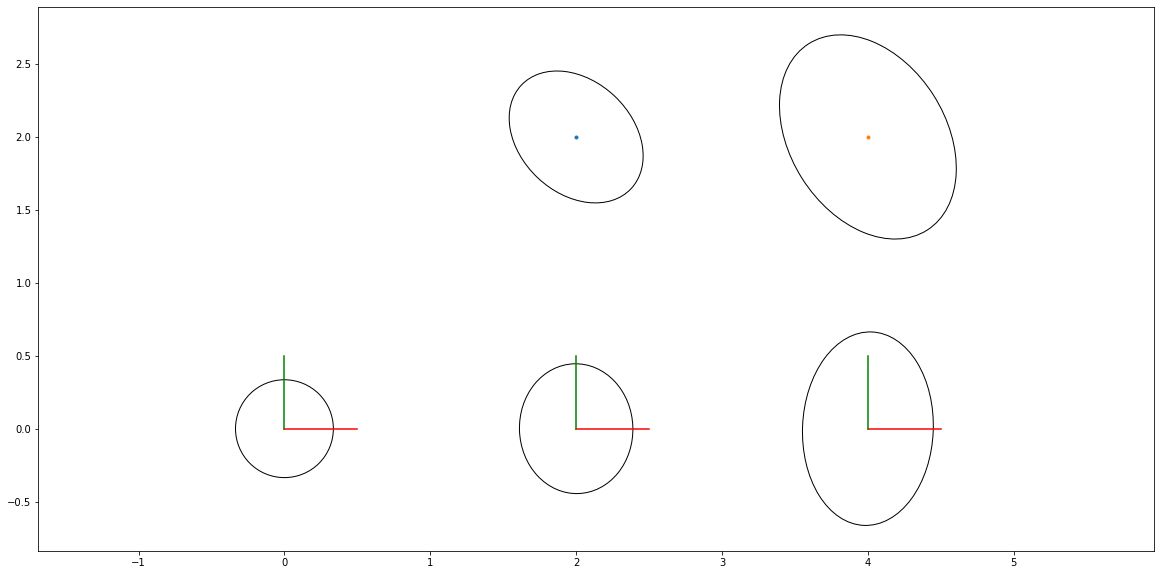

In [3]:
"""
GTSAM Copyright 2010-2018, Georgia Tech Research Corporation,
Atlanta, Georgia 30332-0415
All Rights Reserved
Authors: Frank Dellaert, et al. (see THANKS for the full author list)
See LICENSE for the license information
Simple robotics example using odometry measurements and bearing-range (laser) measurements
Author: Alex Cunningham (C++), Kevin Deng & Frank Dellaert (Python)
"""
# pylint: disable=invalid-name, E1101

from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt

import gtsam
from gtsam.symbol_shorthand import X, L
import gtsam.utils.plot as gtsam_plot


# Create noise models
PRIOR_NOISE = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.3, 0.3, 0.1]))
ODOMETRY_NOISE = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.2, 0.2, 0.1]))
MEASUREMENT_NOISE = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.1, 0.2]))

# Create an empty nonlinear factor graph
graph = gtsam.NonlinearFactorGraph()

# Create the keys corresponding to unknown variables in the factor graph
X1 = X(1)
X2 = X(2)
X3 = X(3)
L1 = L(4)
L2 = L(5)

# Add a prior on pose X1 at the origin. A prior factor consists of a mean and a noise model
graph.add(gtsam.PriorFactorPose2(X1, gtsam.Pose2(0.0, 0.0, 0.0), PRIOR_NOISE))

# Add odometry factors between X1,X2 and X2,X3, respectively
graph.add(gtsam.BetweenFactorPose2(
    X1, X2, gtsam.Pose2(2.0, 0.0, 0.0), ODOMETRY_NOISE))
graph.add(gtsam.BetweenFactorPose2(
    X2, X3, gtsam.Pose2(2.0, 0.0, 0.0), ODOMETRY_NOISE))

# Add Range-Bearing measurements to two different landmarks L1 and L2
graph.add(gtsam.BearingRangeFactor2D(
    X1, L1, gtsam.Rot2.fromDegrees(45), np.sqrt(4.0+4.0), MEASUREMENT_NOISE))
graph.add(gtsam.BearingRangeFactor2D(
    X2, L1, gtsam.Rot2.fromDegrees(90), 2.0, MEASUREMENT_NOISE))
graph.add(gtsam.BearingRangeFactor2D(
    X3, L2, gtsam.Rot2.fromDegrees(90), 2.0, MEASUREMENT_NOISE))

# Create (deliberately inaccurate) initial estimate
initial_estimate = gtsam.Values()
initial_estimate.insert(X1, gtsam.Pose2(-0.25, 0.20, 0.15))
initial_estimate.insert(X2, gtsam.Pose2(2.30, 0.10, -0.20))
initial_estimate.insert(X3, gtsam.Pose2(4.10, 0.10, 0.10))
initial_estimate.insert(L1, gtsam.Point2(1.80, 2.10))
initial_estimate.insert(L2, gtsam.Point2(4.10, 1.80))

# Optimize using Levenberg-Marquardt optimization. The optimizer
# accepts an optional set of configuration parameters, controlling
# things like convergence criteria, the type of linear system solver
# to use, and the amount of information displayed during optimization.
# Here we will use the default set of parameters.  See the
# documentation for the full set of parameters.
params = gtsam.LevenbergMarquardtParams()
optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial_estimate, params)
result = optimizer.optimize()

# Calculate and print marginal covariances for all variables
marginals = gtsam.Marginals(graph, result)

fig = plt.figure(figsize=(20,10))
ax = plt.axes()
for (key, str) in [(X1, "X1"), (X2, "X2"), (X3, "X3")]:
    gtsam_plot.plot_pose2_on_axes(ax, result.atPose2(key), 0.5, marginals.marginalCovariance(key))

for (key, str) in [(L1, "L1"), (L2, "L2")]:
    plot_point2_on_axes(ax, result.atPoint2(key), 0.5, marginals.marginalCovariance(key))
  
ax.axis('equal')
plt.show()